In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import os

In [2]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [85]:
def lineal(x, a, b):
    linea = a*x + b
    return linea
def lloyd_taylor(t, ref, e0):
    # Poner t en centigrados
    t0 = 269
    resp = ref * np.exp(-e0/(t+273.16-t0))
    return resp
def gpp(par, alfa, optimo):
    # optimo = 
    gpp = -(alfa*par*optimo) / (alfa*par+optimo)
    return gpp

In [83]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def indice_acuerdo(x, y):
    diff = (y - x)**2
    long = (np.abs(x) + np.abs(y))**2
    d = 1 - diff.sum()/long.sum()
    return d
def regresion(modelo, x, y, pesos = None):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(modelo, x, y,
                                    sigma = pesos,
                                    p0 = [-0.02, -5]
                                   )
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    residuo = y - predicciones
    acue = indice_acuerdo(y, predicciones)
    return predicciones, ajuste, errores, r_cuadrado, acue, residuo

In [80]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras = 3):
    texto = str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
    return texto
def grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuad, acuerdo,
                   nombres, j = 3
                  ):
    etiqueta = ''
    for i in list(range(len(nombres))):
        valor = cifras_signif(ajuste[i], j)
        error = cifras_signif(errores[i], j)
        etiqueta = (etiqueta
                    + ' ' + nombres[i] + ' = ' + valor
                    + '; std ' + nombres[i] + ' = ' + error
                    + '\n')
    etiqueta = (etiqueta
                + ' R^2 = ' + cifras_signif(r_cuad, j)
                + '; Acuerdo = ' + cifras_signif(acuerdo, j)
               )
    plt.plot(x, y, 'bo', markersize = 2)
    plt.plot(x, predicciones, 'r-',
             label = etiqueta
             )
    plt.legend(fontsize = 20)
    return
def grafico_residuos(x, res):
    plt.plot(x, res, 'bo', markersize = 2)
    plt.axhline(0, color = 'black', linestyle = '--')
    return

In [59]:
def regr_con_grafico(modelo, x, y, xlabel,
                     ylabel, nombres, pesos = None):
    regr = regresion(modelo, x, y, pesos)
    predicciones = regr[0]
    ajuste = regr[1]
    errores = regr[2]
    r_cuadrado = regr[3]
    acuerdo = regr[4]
    res = regr[5]
    plt.subplot(121)
    grafico_modelo(x, y, predicciones, ajuste,
                   errores, r_cuadrado, acuerdo,
                   nombres)
    metadata(xlabel, ylabel)
    plt.subplot(122)
    grafico_residuos(x, res)
    metadata(xlabel, ylabel)
    return ajuste, r_cuadrado, acuerdo, errores

In [7]:
def tabla_metricas(nombres = []):
    cols = ['R2_reg', 'Acuerdo', 'n_aj']
    cols = cols + nombres
    for i in list(range(len(nombres))):
        nombres[i] = 'std ' + nombres[i]
    cols = cols + nombres
    num = len(cols)
    datos = np.zeros((1, num))
    tabla = pd.DataFrame(data = datos, columns = cols)
    return tabla

In [61]:
def analisis(metodo, x, y, xlab, ylab,
             nombres, tabla, pesos = None
             ):
    grafico = plt.figure(figsize = (36, 9)).subplots(1, 2)
    regr = regr_con_grafico(metodo, np.array(x), np.array(y),
                            xlab, ylab, nombres, pesos
                            )
    ajuste = regr[0]
    r_ajuste = regr[1]
    acuerdo = regr[2]
    std_ajuste = regr[3]
    tabla['Acuerdo'][0] = cifras_signif(acuerdo)
    tabla['n_aj'][0] = x.count() 
    tabla['R2_reg'][0] = cifras_signif(r_ajuste)
    for i in list(range(len(nombres))):
        tabla[nombres[i]][0] = ajuste[i]
        tabla['std ' + nombres[i]][0] = std_ajuste[i]
    return grafico, tabla

In [9]:
datos = pd.read_csv(
    #'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Completos_buenos.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [10]:
resumen(datos)

Forma:
 (14442, 38) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar', 'TS1', 'TS2', 'TS3', 'TS4', 'U', 'DIR', 'PP', 'QG1',
       'QG2', 'WET', 'PAR', 'TSH1', 'HS1', 'GH1', 'TSH2', 'HS2', 'GH2', 'TSH3',
       'HS3', 'GH3', 'TSH4', 'HS4', 'GH4', 'PAR.1', '   r_err_co2[%]',
       '   noise_co2[%]'],
      dtype='object') 

 Tipos:
 Year               float64
DoY                float64
Hour               float64
NEE                float64
LE                 float64
H                  float64
Rg                 float64
Tair               float64
Tsoil              float64
rH                 float64
VPD                float64
Ustar              float64
TS1                float64
TS2                float64
TS3                float64
TS4                float64
U                  float64
DIR                float64
PP                 float64
QG1                float64
QG2                float64
WET                float64
PAR     

In [11]:
datos['Error porcent'] = datos['   r_err_co2[%]'] + datos['   noise_co2[%]']
datos['Error'] = abs(datos['Error porcent']/100 * datos['NEE'])

In [12]:
datos_validos = datos[(datos['Rg'] >= 5)
                      & (datos['Ustar'] > 0.14167)
                      & pd.notna(datos['PAR.1'])
                      & pd.notna(datos['NEE'])
                      #& (datos['Error porcent'] < 40)
                      #& (datos['Error'] < 0.5)
                     ]
datos_validos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS3,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error
count,3481.0,3481.000000,3481.000000,3481.000000,3445.000000,3450.000000,3481.000000,3481.000000,3481.000000,3481.000000,...,3345.000000,3345.000000,3480.000000,3480.000000,3480.000000,3.481000e+03,3481.000000,3481.000000,3481.000000,3481.000000
mean,2018.0,257.023556,13.026896,-2.899554,105.272458,112.056937,394.593285,15.010761,12.444306,64.389944,...,0.535526,0.211370,12.602891,0.401729,0.294288,7.403148e+02,16.943555,1.425905,18.369461,0.507343
std,0.0,60.652548,3.401117,3.056969,85.722117,118.065149,293.038496,5.179743,4.008732,15.670783,...,0.030366,0.025953,3.004702,0.036664,0.039684,5.326490e+02,28.235668,2.816832,30.606864,0.953192
min,2018.0,91.000000,5.625000,-21.042500,-187.969055,-86.813431,5.005000,-0.645000,1.940000,22.510000,...,0.450000,0.147000,7.200000,0.220000,0.113000,1.831424e-12,5.981359,0.084813,7.034158,0.000118
1%,2018.0,95.000000,6.125000,-11.810030,-17.322647,-49.890689,6.997000,4.293000,4.340000,30.107000,...,0.458220,0.166500,7.400000,0.322000,0.171000,4.106937e-12,7.178590,0.203559,8.145417,0.011191
10%,2018.0,170.000000,8.625000,-6.816150,13.894765,-16.726424,45.255000,9.180000,7.260000,43.285000,...,0.470500,0.175000,8.824000,0.348950,0.242500,8.343000e+01,8.379208,0.408657,9.274190,0.091356
25%,2018.0,221.000000,10.125000,-4.485400,41.790121,14.689984,143.050000,11.295000,9.047500,52.900000,...,0.539500,0.193000,9.900000,0.381000,0.276000,2.786500e+02,9.424971,0.593299,10.231078,0.180084
50%,2018.0,268.000000,13.125000,-2.509950,85.618862,83.374903,341.650000,14.450000,12.360000,64.870000,...,0.546500,0.211000,12.400000,0.407500,0.308000,6.621500e+02,11.060503,0.821444,11.817868,0.343240
75%,2018.0,305.000000,15.625000,-1.021700,151.028153,190.486397,596.100000,18.150000,15.587500,75.990000,...,0.551000,0.229000,15.200000,0.427000,0.319000,1.135500e+03,14.147782,1.102459,15.155517,0.569497
90%,2018.0,328.000000,17.625000,0.390900,225.773842,282.617030,855.000000,21.810000,17.937500,85.700000,...,0.557500,0.249000,16.731000,0.445000,0.339000,1.536000e+03,25.007089,2.544826,27.329772,0.871218


<ErrorbarContainer object of 3 artists>

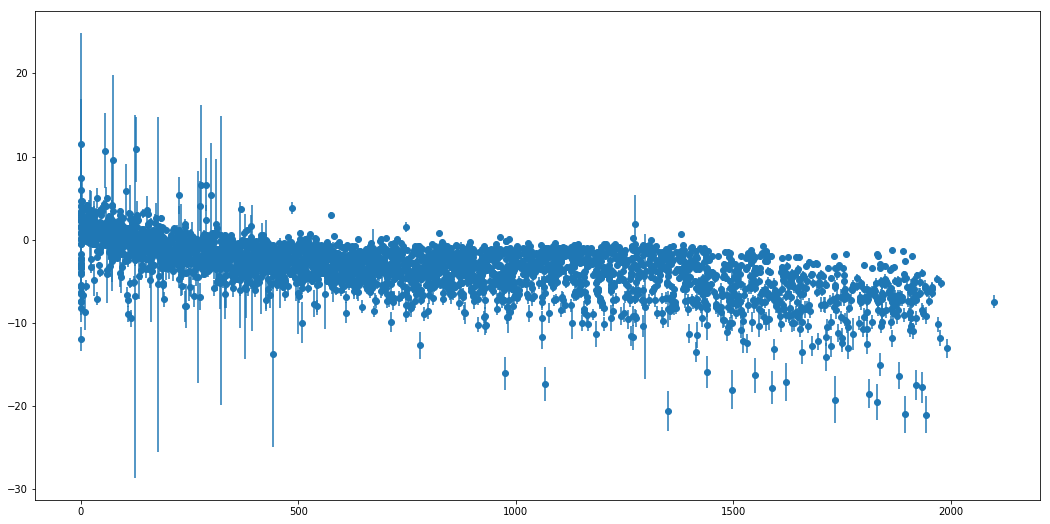

In [13]:
plt.figure(figsize=(18,9))
plt.errorbar(datos_validos['PAR.1'], datos_validos['NEE'], datos_validos['Error'], fmt='o')

In [74]:
datos_validos = datos[(datos['Rg'] >= 5)
                      & (datos['Ustar'] > 0.14167)
                      & pd.notna(datos['PAR.1'])
                      & pd.notna(datos['NEE'])
                      & (datos['Error porcent'] < 40)
                      & (datos['Error'] < 0.5)
                     ]
datos_validos = datos_validos.sort_values('PAR.1')
datos_validos.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,HS3,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error
count,2334.0,2334.000000,2334.000000,2334.000000,2320.000000,2314.000000,2334.000000,2334.000000,2334.000000,2334.000000,...,2262.000000,2262.000000,2333.00000,2333.000000,2333.000000,2.334000e+03,2334.000000,2334.000000,2334.000000,2334.000000
mean,2018.0,248.463582,13.581298,-1.738751,87.187199,90.066526,348.031992,14.550666,11.764757,63.401832,...,0.535534,0.206904,11.89176,0.405133,0.290665,6.538319e+02,12.335730,1.056832,13.392563,0.246983
std,0.0,54.272164,3.420021,1.743769,69.487686,100.553640,257.043759,5.032655,3.821103,15.281002,...,0.030018,0.023691,2.81330,0.033889,0.035698,4.698327e+02,4.992433,0.909983,5.456669,0.133086
min,2018.0,91.000000,5.625000,-6.393150,-187.969055,-86.813431,5.005000,-0.645000,2.772500,23.730000,...,0.452500,0.147000,7.20000,0.223000,0.167000,1.831424e-12,6.720463,0.084813,7.501480,0.000118
1%,2018.0,95.000000,6.125000,-5.259653,-11.595369,-53.788753,6.803300,4.334850,4.169125,30.706600,...,0.458500,0.167000,7.38660,0.328660,0.172000,6.311600e+00,7.281291,0.223382,8.194051,0.007752
10%,2018.0,172.000000,8.625000,-3.908790,12.117074,-21.016822,39.488000,9.161500,7.086500,42.946500,...,0.470500,0.175000,8.56200,0.354600,0.244000,7.066100e+01,8.417660,0.441578,9.323646,0.069408
25%,2018.0,217.000000,11.125000,-2.969738,35.671846,9.529268,127.787500,11.005000,8.785000,52.503750,...,0.540000,0.189625,9.50000,0.386500,0.275000,2.428250e+02,9.384076,0.638286,10.216061,0.139618
50%,2018.0,254.000000,14.125000,-1.799100,73.634502,67.063066,306.025000,13.822500,11.608750,63.647500,...,0.546500,0.207000,11.60000,0.409500,0.292000,5.831000e+02,10.815565,0.838839,11.634959,0.240843
75%,2018.0,290.000000,16.625000,-0.708988,122.582547,156.250095,528.875000,17.517500,14.665625,75.068750,...,0.550500,0.223000,14.10000,0.430500,0.313500,1.005625e+03,13.176820,1.063047,14.146283,0.356424
90%,2018.0,313.000000,17.625000,0.605485,181.820470,238.406474,717.525000,20.898000,17.053000,84.100000,...,0.557000,0.236000,16.18400,0.445500,0.333000,1.334050e+03,17.854024,1.804144,19.363023,0.432906


<ErrorbarContainer object of 3 artists>

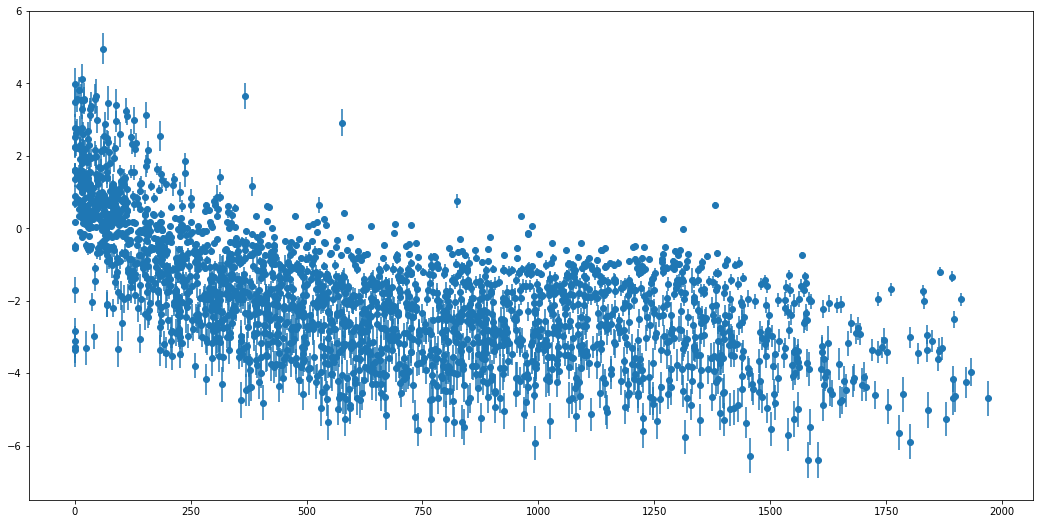

In [75]:
plt.figure(figsize=(18,9))
plt.errorbar(datos_validos['PAR.1'], datos_validos['NEE'], datos_validos['Error'], fmt='o')

In [76]:
dias = np.arange(60, 420, 60)
ref = [8.76,5.47, 9.35, 6.39, 9.6]
e0 = [19.81, 22.89, 30.43, 23.37, 29.62]
datos_validos['GPP'] = datos_validos['Year']
for i in list(range(1, len(dias))):
    desde = dias[i-1]
    hasta = dias[i]
    datos_bimens = datos_validos[(datos_validos['DoY'] >= desde)
                             & (datos_validos['DoY'] < hasta)
                             ]
    datos_bimens['GPP'] = datos_bimens['NEE'] - lloyd_taylor(datos_bimens['Tsoil'],
                                                             ref[i-1], e0[i-1]
                                                            )
    datos_validos['GPP'].loc[datos_bimens.index] = datos_bimens['GPP']

C:\Users\BIOMET\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [77]:
datos_validos.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,...,GH3,TSH4,HS4,GH4,PAR.1,r_err_co2[%],noise_co2[%],Error porcent,Error,GPP
count,2334.0,2334.000000,2334.000000,2334.000000,2320.000000,2314.000000,2334.000000,2334.000000,2334.000000,2334.000000,...,2262.000000,2333.00000,2333.000000,2333.000000,2.334000e+03,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000
mean,2018.0,248.463582,13.581298,-1.738751,87.187199,90.066526,348.031992,14.550666,11.764757,63.401832,...,0.206904,11.89176,0.405133,0.290665,6.538319e+02,12.335730,1.056832,13.392563,0.246983,-3.214803
std,0.0,54.272164,3.420021,1.743769,69.487686,100.553640,257.043759,5.032655,3.821103,15.281002,...,0.023691,2.81330,0.033889,0.035698,4.698327e+02,4.992433,0.909983,5.456669,0.133086,1.828672
min,2018.0,91.000000,5.625000,-6.393150,-187.969055,-86.813431,5.005000,-0.645000,2.772500,23.730000,...,0.147000,7.20000,0.223000,0.167000,1.831424e-12,6.720463,0.084813,7.501480,0.000118,-8.858811
25%,2018.0,217.000000,11.125000,-2.969738,35.671846,9.529268,127.787500,11.005000,8.785000,52.503750,...,0.189625,9.50000,0.386500,0.275000,2.428250e+02,9.384076,0.638286,10.216061,0.139618,-4.459484
50%,2018.0,254.000000,14.125000,-1.799100,73.634502,67.063066,306.025000,13.822500,11.608750,63.647500,...,0.207000,11.60000,0.409500,0.292000,5.831000e+02,10.815565,0.838839,11.634959,0.240843,-3.098851
75%,2018.0,290.000000,16.625000,-0.708988,122.582547,156.250095,528.875000,17.517500,14.665625,75.068750,...,0.223000,14.10000,0.430500,0.313500,1.005625e+03,13.176820,1.063047,14.146283,0.356424,-1.929467
max,2018.0,344.000000,20.125000,4.960900,377.007629,445.444931,1092.000000,32.485000,22.372500,93.850000,...,0.265000,18.00000,0.468500,0.351500,1.968500e+03,39.226672,12.249443,39.997284,0.499396,2.314457


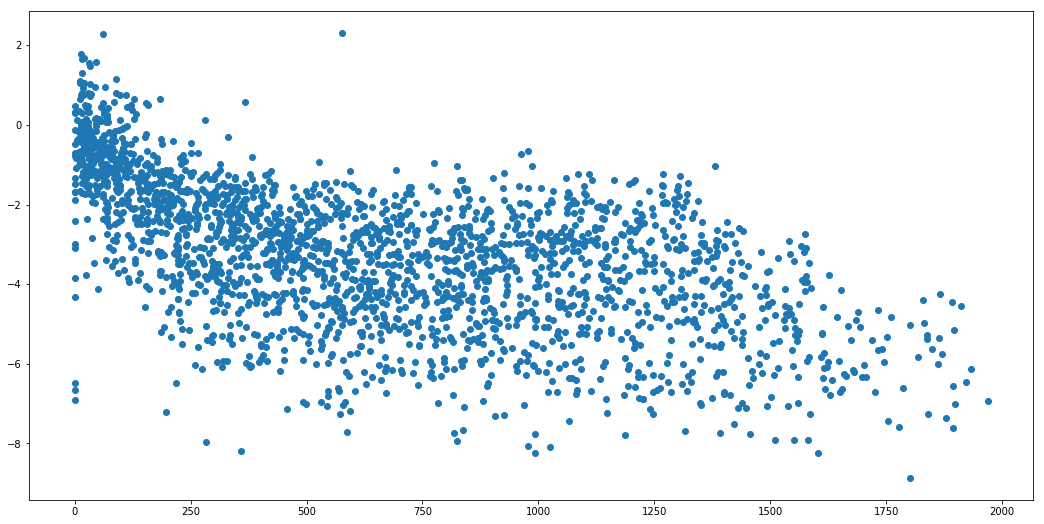

In [78]:
plt.figure(figsize=(18,9))
plt.plot(datos_validos['PAR.1'], datos_validos['GPP'], 'o')

In [86]:
modelo = [gpp, 'Alfa', 'Optimo']
camino = 'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Fotosintesis\\'
#camino = 'C:\\Users\\nahue\\Desktop\\Tesis_2\\Fotosintesis\\'
guardado = camino + modelo[0].__name__ + '\\'
if not os.path.exists(guardado):
    os.makedirs(guardado)
titulo = 'Desde 0 Hasta 360'
graf, result = analisis(modelo[0],
                        datos_validos['PAR.1'],
                        datos_validos['GPP'],
                        'micromol/(m^2 s)', 'micromol/(m^2 s)',
                        modelo[1:],
                        tabla_metricas(modelo[1:]),
                        )
plt.savefig(guardado + titulo +'.png')
plt.close()
result['Desde'] = datos_validos['DoY'].min()
result['Hasta'] = datos_validos['DoY'].max()
for i in list(range(1, len(dias))):
    desde = dias[i-1]
    hasta = dias[i]
    datos_bimens = datos_validos[(datos_validos['DoY'] >= desde)
                                 & (datos_validos['DoY'] < hasta)
                                 ]
    titulo = 'Desde ' + str(desde) + ' Hasta ' + str(hasta)
    graf, result_2 = analisis(modelo[0],
                              datos_bimens['PAR.1'],
                              datos_bimens['GPP'],
                              'micromol/(m^2 s)', 'micromol/(m^2 s)',
                              modelo[1:],
                              tabla_metricas(modelo[1:]),
                              )
    plt.savefig(guardado + titulo +'.png')
    plt.close()
    result_2['Desde'] = datos_bimens['DoY'].min()
    result_2['Hasta'] = datos_bimens['DoY'].max()
    result = result.append(result_2, ignore_index = True)
result.to_csv(guardado + 'Resultados.csv',
              sep = '\t',
              na_rep = -9999,
              index = False,
              encoding = 'ascii'
              )
print('Listo!')

Listo!
